# 0) Pré-requis et chargement

In [2]:
!pip install -q igraph leidenalg pynndescent scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 57.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 130.9 MB/s eta 0:00:00


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import numpy as np
import pandas as pd
from pathlib import Path

emb = np.load("/content/drive/Othercomputers/Mon ordinateur portable/Bureau/Audit_Report/embeddings/jina_sample.npy").astype(np.float32)
meta = pd.read_parquet("/content/drive/Othercomputers/Mon ordinateur portable/Bureau/Audit_Report/embeddings/meta_sample.parquet")

assert len(meta) == emb.shape[0]
print(meta.shape, emb.shape)

(22965, 10) (22965, 768)


# 1) kNN Graph + Leiden (rapide & performant)
- Paramètres recommandés (pour 22 965 docs)

 * k = 30

 * resolution = 1.0

 * similarity_threshold = 0.25 (coupe les arêtes faibles)

In [6]:
from pynndescent import NNDescent
import igraph as ig
import leidenalg

k = 30
resolution = 1.0
sim_threshold = 0.25

index = NNDescent(emb, metric="cosine", n_neighbors=k+1, random_state=42)
neighbors, distances = index.neighbor_graph

# retire soi-même
neighbors = neighbors[:, 1:]
distances = distances[:, 1:]  # cosine distance

n = emb.shape[0]
edges = []
weights = []

for i in range(n):
    for j, d in zip(neighbors[i], distances[i]):
        sim = 1.0 - float(d)
        if sim < sim_threshold:
            continue
        j = int(j)
        if i == j:
            continue
        edges.append((i, j))
        weights.append(sim)

g = ig.Graph(n=n, edges=edges, directed=False)
g.es["weight"] = weights

partition = leidenalg.find_partition(
    g,
    leidenalg.RBConfigurationVertexPartition,
    weights="weight",
    resolution_parameter=resolution,
    seed=42
)

meta["cluster"] = np.array(partition.membership, dtype=int)
print("n_clusters:", meta["cluster"].nunique())
meta["cluster"].value_counts().describe()

n_clusters: 6


,count
count,6.000000
mean,3827.500000
std,610.459417
min,3221.000000
25%,3461.500000
50%,3575.000000
75%,4169.250000
max,4803.000000


# 2) Raffinement A : fusionner les clusters trop proches (merge)
Idée

* Calculer le centroïde (moyenne embedding) par cluster

* Si deux centroïdes sont très proches (cosine similarity > seuil), on fusionne

* Seuil conseillé : merge_sim = 0.92 (tu peux tester 0.90–0.95)

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

merge_sim = 0.92

def compute_centroids(labels, emb):
    df_lab = pd.DataFrame({"cluster": labels})
    centroids = []
    cluster_ids = []
    for cid, idx in df_lab.groupby("cluster").indices.items():
        c = emb[idx].mean(axis=0)
        # renormalise
        c = c / (np.linalg.norm(c) + 1e-12)
        centroids.append(c)
        cluster_ids.append(cid)
    return np.vstack(centroids), np.array(cluster_ids)

labels = meta["cluster"].values
centroids, cids = compute_centroids(labels, emb)
S = cosine_similarity(centroids)  # (C,C)

# Union-Find pour fusionner
parent = {int(c): int(c) for c in cids}
def find(x):
    while parent[x] != x:
        parent[x] = parent[parent[x]]
        x = parent[x]
    return x
def union(a, b):
    ra, rb = find(a), find(b)
    if ra != rb:
        parent[rb] = ra

C = len(cids)
for i in range(C):
    for j in range(i+1, C):
        if S[i, j] >= merge_sim:
            union(int(cids[i]), int(cids[j]))

# map old -> merged root
map_merge = {cid: find(cid) for cid in cids}
meta["cluster_m"] = meta["cluster"].map(map_merge).astype(int)

print("clusters before:", meta["cluster"].nunique())
print("clusters after merge:", meta["cluster_m"].nunique())

clusters before: 6
clusters after merge: 3


## Visualisation PCA 2D




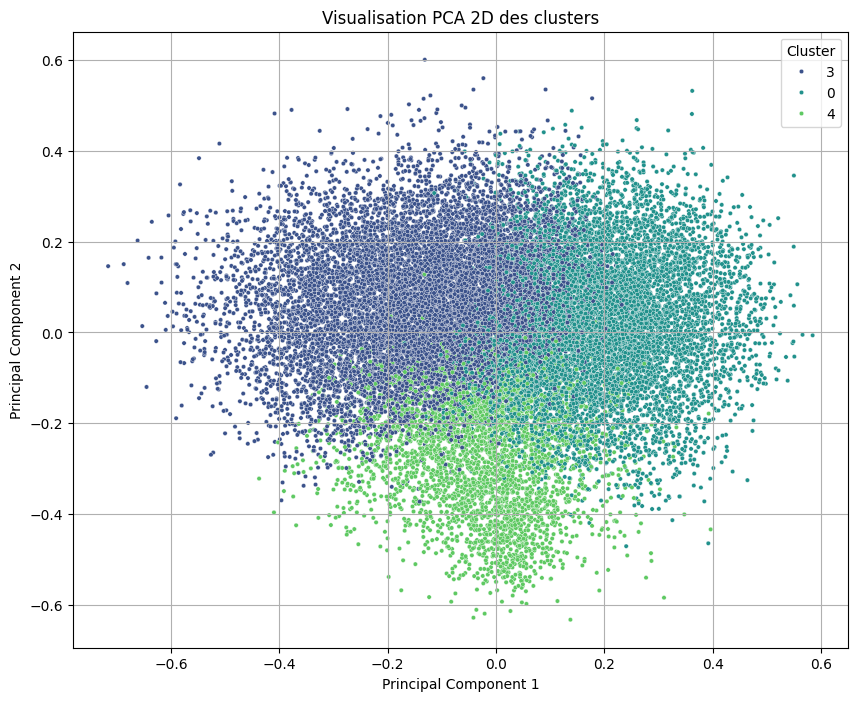

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Apply PCA to reduce dimensions to 2
pca = PCA(n_components=2, random_state=42)
emb_pca_2d = pca.fit_transform(emb)

# 2. Create a DataFrame for plotting
pca_df = pd.DataFrame(emb_pca_2d, columns=['PC1', 'PC2'])
pca_df['cluster_m'] = meta['cluster_m'].astype(str)

# 3. Create the scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='PC1',
    y='PC2',
    hue='cluster_m',
    data=pca_df,
    palette='viridis',
    s=10
)

# 4. Add title and show plot
plt.title('Visualisation PCA 2D des clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()


## Visualisation UMAP 2D

### Subtask:
Appliquez UMAP (Uniform Manifold Approximation and Projection) sur les embeddings ('emb') pour réduire les dimensions à 2.


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


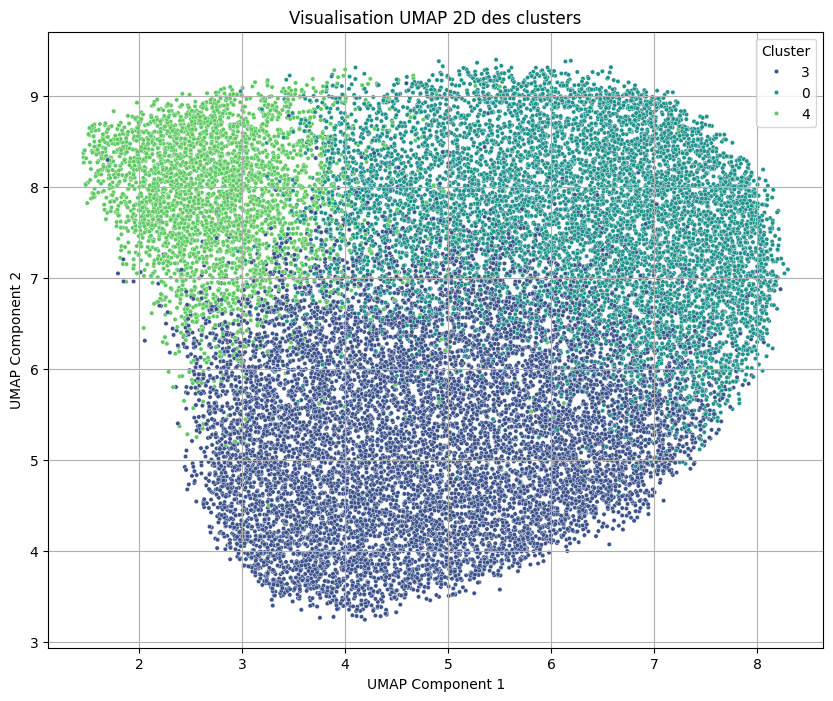

In [13]:
import umap
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 3. Initialize a UMAP object with n_components=2
umap_reducer = umap.UMAP(n_components=2, random_state=42)

# 4. Apply UMAP to the embeddings
emb_umap_2d = umap_reducer.fit_transform(emb)

# 5. Create a DataFrame for plotting
umap_df = pd.DataFrame(emb_umap_2d, columns=['UMAP1', 'UMAP2'])

# 6. Add the 'cluster_m' column to the DataFrame
umap_df['cluster_m'] = meta['cluster_m'].astype(str)

# 7. Create a 2D scatter plot
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='UMAP1',
    y='UMAP2',
    hue='cluster_m',
    data=umap_df,
    palette='viridis',
    s=10
)

# 8. Add title and labels
plt.title('Visualisation UMAP 2D des clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

## Visualisation PCA 3D




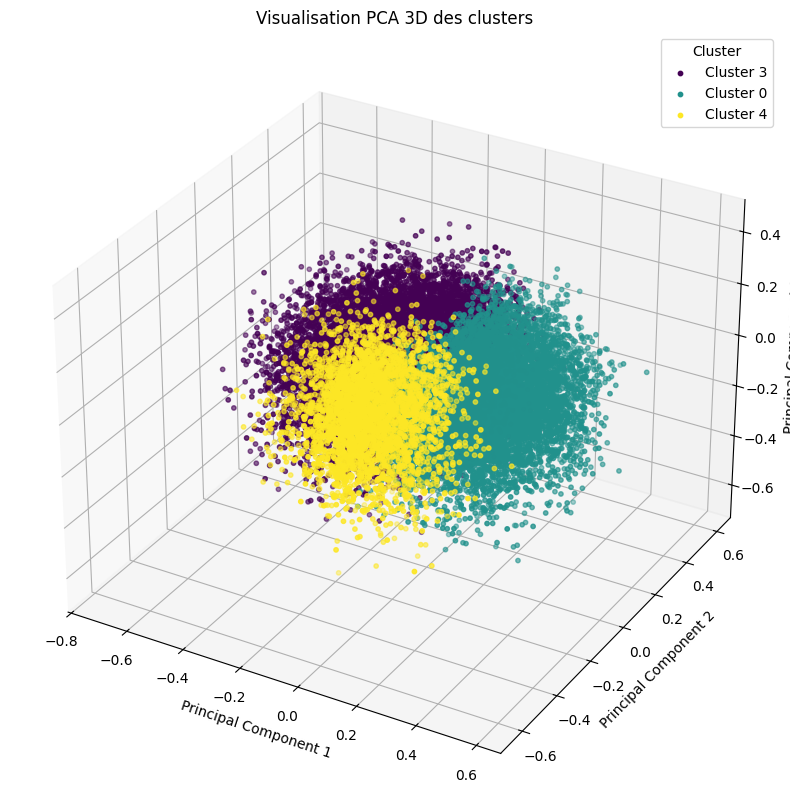

In [15]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# 1. Initialize PCA object with 3 components
pca_3d = PCA(n_components=3, random_state=42)

# 2. Apply PCA to the embeddings
emb_pca_3d = pca_3d.fit_transform(emb)

# 3. Create a DataFrame for 3D plotting
pca_df_3d = pd.DataFrame(emb_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d['cluster_m'] = meta['cluster_m'].astype(str)

# 4. Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels for legend
unique_clusters = pca_df_3d['cluster_m'].unique()

# Define a colormap using the non-deprecated method and create a color cycler
cmap = plt.colormaps.get_cmap('viridis')
colors = [cmap(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]

for i, cluster_label in enumerate(unique_clusters):
    subset = pca_df_3d[pca_df_3d['cluster_m'] == cluster_label]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=f'Cluster {cluster_label}',
        color=colors[i],
        s=10
    )

# Add title and labels
ax.set_title('Visualisation PCA 3D des clusters')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
ax.legend(title='Cluster')

# Display the plot
plt.grid(True)
plt.show()

## Visualisation UMAP 3D



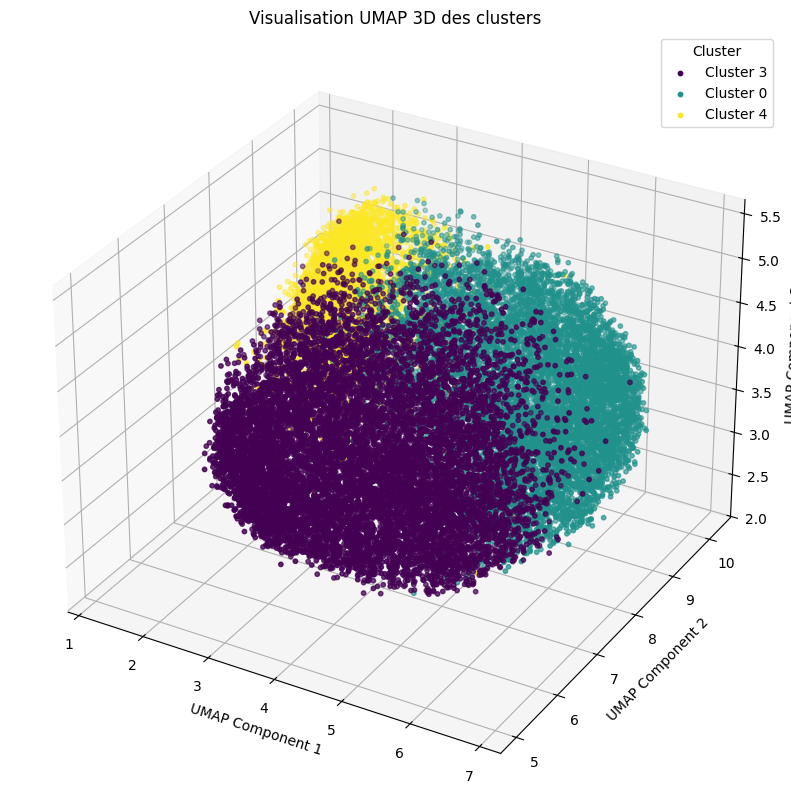

In [16]:
import umap
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# 2. Initialize a UMAP reducer object with n_components=3 and random_state=42
# Added n_jobs=1 to suppress potential warning when random_state is set
umap_reducer_3d = umap.UMAP(n_components=3, random_state=42, n_jobs=1)

# 3. Apply UMAP to the embeddings
emb_umap_3d = umap_reducer_3d.fit_transform(emb)

# 4. Create a DataFrame for 3D plotting
umap_df_3d = pd.DataFrame(emb_umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])

# 5. Add the 'cluster_m' column to the DataFrame
umap_df_3d['cluster_m'] = meta['cluster_m'].astype(str) # Convert to string for discrete colors

# 6. Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels for legend
unique_clusters = umap_df_3d['cluster_m'].unique()

# Define a colormap and create a color cycler
cmap = plt.colormaps.get_cmap('viridis')
# Ensure colors are assigned distinctly, handling the case of single cluster
if len(unique_clusters) > 1:
    colors = [cmap(i / (len(unique_clusters) - 1)) for i in range(len(unique_clusters))]
else:
    colors = [cmap(0.5)]

for i, cluster_label in enumerate(unique_clusters):
    subset = umap_df_3d[umap_df_3d['cluster_m'] == cluster_label]
    ax.scatter(
        subset['UMAP1'],
        subset['UMAP2'],
        subset['UMAP3'],
        label=f'Cluster {cluster_label}',
        color=colors[i],
        s=10
    )

# 7. Add title and labels
ax.set_title('Visualisation UMAP 3D des clusters')
ax.set_xlabel('UMAP Component 1')
ax.set_ylabel('UMAP Component 2')
ax.set_zlabel('UMAP Component 3')

# 8. Add legend and display the plot
ax.legend(title='Cluster')
plt.grid(True)
plt.show()

# 3) Raffinement B : split des clusters trop hétérogènes (split)
Idée (pratique et rapide)

On repère les “gros clusters fourre-tout” et on reclusterise à l’intérieur (kNN+Leiden local).
Pour un MVP : on split uniquement les clusters qui dépassent un seuil de taille.

In [29]:
split_size_threshold = 3500

# 1. Initialize cluster_final
meta["cluster_final"] = meta["cluster_m"].copy()

# 3. Determine the current maximum cluster ID
current_max_cluster_id = meta["cluster_m"].max() # Use cluster_m as base

print("Initial clusters in cluster_m:", meta["cluster_m"].nunique())
print("Initial clusters in cluster_final (before splitting):", meta["cluster_final"].nunique())
print("Current max cluster ID:", current_max_cluster_id)

Initial clusters in cluster_m: 3
Initial clusters in cluster_final (before splitting): 3
Current max cluster ID: 4


In [30]:
new_cluster_id_counter = current_max_cluster_id + 1

for cluster_id in meta["cluster_m"].unique():
    cluster_indices = meta[meta["cluster_m"] == cluster_id].index
    cluster_size = len(cluster_indices)

    if cluster_size > split_size_threshold:
        print(f"Splitting large cluster {cluster_id} with size {cluster_size}")

        # 6a. Extract embeddings and original indices for the large cluster
        emb_subset = emb[cluster_indices]
        original_subset_indices = cluster_indices.to_numpy() # Convert to numpy for direct indexing

        # Define local_k, ensuring it's not larger than the number of items in the subset - 1
        local_k = min(k, len(emb_subset) - 1)
        if local_k < 1:
            print(f"  Skipping split for cluster {cluster_id}: subset too small for kNN ({len(emb_subset)} items).")
            continue

        # 6b. Apply NNDescent to this subset of embeddings
        local_index = NNDescent(emb_subset, metric="cosine", n_neighbors=local_k + 1, random_state=42)
        local_neighbors, local_distances = local_index.neighbor_graph

        # Remove self-loops (first neighbor is always self if n_neighbors includes self)
        local_neighbors = local_neighbors[:, 1:]
        local_distances = local_distances[:, 1:]

        local_edges = []
        local_weights = []

        # 6c. Construct a local igraph.Graph object
        for i in range(len(emb_subset)):
            for j_local, d_local in zip(local_neighbors[i], local_distances[i]):
                sim_local = 1.0 - float(d_local)
                if sim_local < sim_threshold:
                    continue
                # Map local index j_local back to the original index within the subset for edge creation
                # This is important for the graph to represent connections within the subset
                local_edges.append((i, j_local))
                local_weights.append(sim_local)

        if not local_edges: # If no edges were formed after similarity thresholding
            print(f"  No strong edges found for cluster {cluster_id} after thresholding. Skipping split.")
            continue

        local_g = ig.Graph(n=len(emb_subset), edges=local_edges, directed=False)
        local_g.es["weight"] = local_weights

        # 6d. Apply leidenalg.find_partition to this local graph
        local_partition = leidenalg.find_partition(
            local_g,
            leidenalg.RBConfigurationVertexPartition,
            weights="weight",
            resolution_parameter=resolution, # resolution is from previous cell, typically 1.0
            seed=42
        )

        # 6e. Assign new, globally unique cluster IDs
        local_memberships = np.array(local_partition.membership, dtype=int)
        unique_local_clusters = np.unique(local_memberships)

        # Map local sub-cluster IDs to new global IDs
        local_to_global_id_map = {}
        for local_cid in unique_local_clusters:
            local_to_global_id_map[local_cid] = new_cluster_id_counter
            new_cluster_id_counter += 1

        # 6f. Update the cluster_final column in meta
        for i, original_idx in enumerate(original_subset_indices):
            local_cid = local_memberships[i]
            meta.loc[original_idx, "cluster_final"] = local_to_global_id_map[local_cid]

# 7. Ensure that the cluster_final column in meta is of integer type.
meta["cluster_final"] = meta["cluster_final"].astype(int)

# 8. Print results
print("\nClusters in cluster_m (before splitting large ones):", meta["cluster_m"].nunique())
print("Clusters in cluster_final (after splitting large ones):", meta["cluster_final"].nunique())
print("\nDescriptive statistics of final cluster sizes:")
print(meta["cluster_final"].value_counts().describe())

Splitting large cluster 3 with size 11046
Splitting large cluster 0 with size 8466

Clusters in cluster_m (before splitting large ones): 3
Clusters in cluster_final (after splitting large ones): 13

Descriptive statistics of final cluster sizes:
count      13.000000
mean     1766.538462
std       760.209578
min       182.000000
25%      1396.000000
50%      1934.000000
75%      2093.000000
max      3453.000000
Name: count, dtype: float64


# 3D visualisation avec PCA



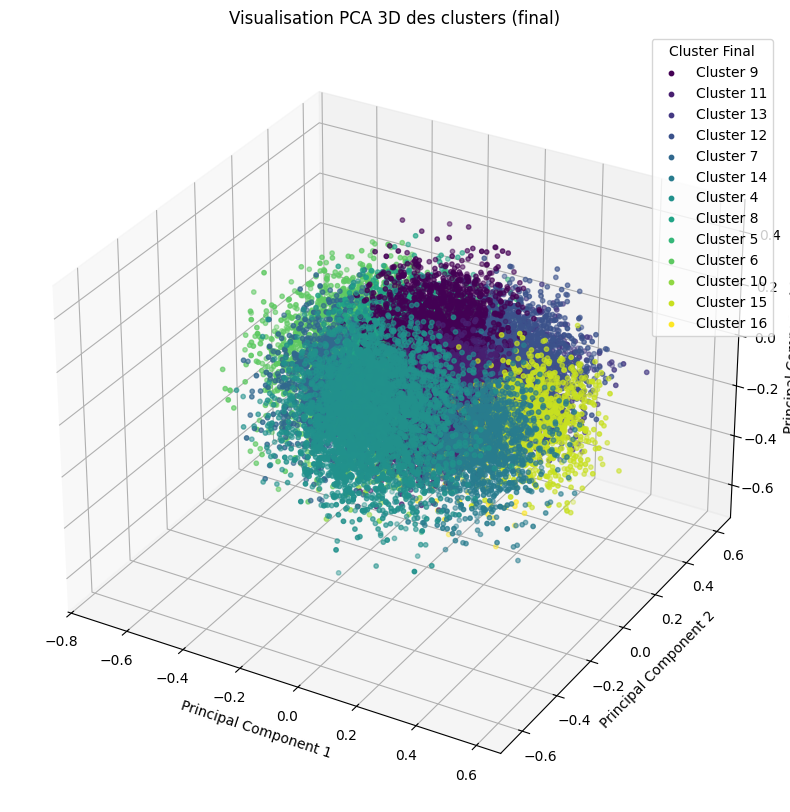

In [31]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd

# Create a DataFrame for 3D plotting with the final clusters
pca_df_3d_final = pd.DataFrame(emb_pca_3d, columns=['PC1', 'PC2', 'PC3'])
pca_df_3d_final['cluster_final'] = meta['cluster_final'].astype(str)

# Create a 3D scatter plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Get unique cluster labels for legend
unique_clusters_final = pca_df_3d_final['cluster_final'].unique()

# Define a colormap using the non-deprecated method
cmap_final = plt.colormaps.get_cmap('viridis')
colors_final = [cmap_final(i / (len(unique_clusters_final) - 1)) for i in range(len(unique_clusters_final))]

for i, cluster_label in enumerate(unique_clusters_final):
    subset = pca_df_3d_final[pca_df_3d_final['cluster_final'] == cluster_label]
    ax.scatter(
        subset['PC1'],
        subset['PC2'],
        subset['PC3'],
        label=f'Cluster {cluster_label}',
        color=colors_final[i],
        s=10
    )

# Add title and labels
ax.set_title('Visualisation PCA 3D des clusters (final)')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')

# Add legend
ax.legend(title='Cluster Final')

# Display the plot
plt.grid(True)
plt.show()

## Identifier les clusters les plus petits



In [35]:
cluster_counts = meta['cluster_final'].value_counts().sort_values(ascending=True)

print("Two or three smallest clusters:")
print(cluster_counts.head(3))

Two or three smallest clusters:
cluster_final
16     182
15    1061
10    1323
Name: count, dtype: int64


In [41]:
# Export the DataFrame containing the selected clusters' data to a Parquet file
selected_docs.to_parquet('selected_clusters_data.parquet', index=False)

print("Le DataFrame 'selected_docs' a été exporté avec succès vers 'selected_clusters_data.parquet'.")
print("Vous pouvez le télécharger depuis le panneau de fichiers de Colab.")

Le DataFrame 'selected_docs' a été exporté avec succès vers 'selected_clusters_data.parquet'.
Vous pouvez le télécharger depuis le panneau de fichiers de Colab.
